In [1]:
import pandas as pd
import sklearn
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import numpy as np

In [2]:
crime_property_light_population = pd.read_csv("./model_data/crime_light_density.csv")
crime_property_light_population.fillna(method='ffill', inplace=True)
crime_property_light_population.head()

,Unnamed: 0,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,zipcode,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density
0,0,Auto Theft,E18,N,2019-10-13 09:28:24,2019,10,Sunday,9,LINCOLN ST,42.259518,-71.121563,2136,6206.9,455.644447,21.073507,0.437849
1,1,Auto Theft,E18,N,2019-10-12 20:11:26,2019,10,Saturday,20,METROPOLITAN AVE,42.262092,-71.116710,2136,6206.9,455.644447,21.073507,0.437849
2,2,Auto Theft,D14,N,2019-10-12 15:12:43,2019,10,Saturday,15,ALLSTON ST,42.352375,-71.135096,2134,16212.0,2250.588503,63.554783,0.582893
3,3,Auto Theft,D4,N,2019-10-12 04:41:52,2019,10,Saturday,4,SAINT JAMES AVE,42.349476,-71.076402,2116,32724.1,14799.401260,480.463801,0.656585
4,4,Auto Theft,A15,N,2019-10-02 08:08:49,2019,10,Wednesday,8,N MEAD ST,42.381846,-71.066551,2129,12192.0,278.377510,165.249738,0.678941


In [3]:
predictors = ['OFFENSE_CODE_GROUP','SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Population density (per square mile of land area)', 'BLDG_VAL', 'LAND_VAL','light_density', 'Lat', 'Long']

df = crime_property_light_population[predictors]

print(len(pd.DataFrame(df.OFFENSE_CODE_GROUP.value_counts())))
print(pd.DataFrame(df.OFFENSE_CODE_GROUP.value_counts()).head(10))


property_crime = ["Larceny", "Larceny From Motor Vehicle"]
violent_crime = ["Simple Assault", "Aggravated Assault", "Robbery", "Homicide", "Sexual Assault"]


df_property_crime = df[df['OFFENSE_CODE_GROUP'].isin(property_crime)]
df_property_crime= df_property_crime.assign(OFFENSE_CODE_GROUP='Property Crime')

66
                                 OFFENSE_CODE_GROUP
Motor Vehicle Accident Response               40471
Larceny                                       33610
Medical Assistance                            31105
Investigate Person                            23700
Other                                         22575
Simple Assault                                20002
Vandalism                                     19376
Drug Violation                                19205
Verbal Disputes                               17538
Investigate Property                          14395


In [4]:
df_motor_vehicle_accident = df[df['OFFENSE_CODE_GROUP'] == 'Motor Vehicle Accident Response']

df_violent = df[df['OFFENSE_CODE_GROUP'].isin(violent_crime)]
df_violent= df_violent.assign(OFFENSE_CODE_GROUP='Violent Crime')

df_medical = df[df['OFFENSE_CODE_GROUP'] == 'Medical Assistance']
df_medical= df_medical.assign(OFFENSE_CODE_GROUP='Medical Assistance')

df_drug = df[df['OFFENSE_CODE_GROUP'] == 'Drug Violation']

df = pd.concat([df_property_crime, df_motor_vehicle_accident, df_violent, df_medical, df_drug])

In [5]:
print(df.shape)
df.OFFENSE_CODE_GROUP.value_counts()

(172921, 11)


Property Crime                     46743
Motor Vehicle Accident Response    40471
Violent Crime                      35397
Medical Assistance                 31105
Drug Violation                     19205
Name: OFFENSE_CODE_GROUP, dtype: int64

In [6]:
# add light data's lat long
# add graffiti data's lat long
# analyze the max and min of the concatenated lat long respectively
# bin it
# merge with binning 
from sklearn.preprocessing import KBinsDiscretizer


#Western most coord: 42.281549, -71.191510
#Eastern most: 42.325468, -70.922188
#southern most: 42.227155, -71.130342
#northern most: 42.397988, -71.000505
grid_lat = np.linspace(42.2267, 42.4, 192, endpoint='False')
grid_lat_pd = pd.DataFrame(grid_lat, columns=["Lat"])

grid_long = np.linspace(-71.192, -70.9225, 220, endpoint='False')
grid_long_pd = pd.DataFrame(grid_long, columns=["Long"])
#Boston City
#21.96 km wide ==> 220 bins , 100m grid
#19.20 km long ==> 192 bins, 100m grid
#########################
lat_bin_count = 192
long_bin_count = 220
#########################
lat_enc = KBinsDiscretizer(n_bins=lat_bin_count,
                           strategy='uniform', encode='ordinal')
long_enc = KBinsDiscretizer(n_bins=long_bin_count,
                            strategy='uniform', encode='ordinal')

# Boston City's Rectangular boundary:
# lat : 42.227155 ~ 42.397988
# long : -71.191510 ~ -70.922188
boston_west = -71.191512
boston_east = -70.922185
boston_north = 42.397990
boston_south = 42.227150
df = df[df['Lat'] <= 42.397990]
df = df[df['Lat'] >= 42.227150]
df = df[df['Long'] <= -70.922185]
df = df[df['Long'] >= -71.191512]
print(len(df)) # result : 147858 ==> we don't lose any data (all rows are accurate)
lat_enc.fit(pd.DataFrame(grid_lat_pd.Lat))
long_enc.fit(pd.DataFrame(grid_long_pd.Long))

df["latbin"] = lat_enc.transform(pd.DataFrame(df.Lat))
df["longbin"] = long_enc.transform(pd.DataFrame(df.Long))

df.head()

172921


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin
21,Property Crime,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,-71.052794,126.0,114.0
47,Property Crime,N,9,Saturday,23,19926.9,560.432683,189.333050,1.000000,42.344396,-71.086320,130.0,86.0
87,Property Crime,N,9,Saturday,20,10617.5,1409.245482,46.711201,0.529223,42.319293,-71.111782,103.0,66.0
90,Property Crime,N,9,Wednesday,4,14884.4,1040.984096,31.260815,0.640733,42.306587,-71.067479,88.0,102.0
93,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.291265,-71.068114,72.0,101.0


In [7]:
light = pd.read_csv('./model_data/streetlight_locations.csv')
light = light[["Lat", "Long"]]

#########
lat_long_multiplier = 2 # 2 : 40.6

lat_bin_count3 = lat_bin_count * lat_long_multiplier
long_bin_count3 = long_bin_count * lat_long_multiplier
lat_enc3 = KBinsDiscretizer(n_bins=lat_bin_count3, strategy='uniform', encode='ordinal')
long_enc3 = KBinsDiscretizer(n_bins=long_bin_count3, strategy='uniform', encode='ordinal')

lat_enc3.fit(pd.DataFrame(grid_lat_pd.Lat))
long_enc3.fit(pd.DataFrame(grid_long_pd.Long))

df["latbin3"] = lat_enc3.transform(pd.DataFrame(df.Lat))
df["longbin3"] = long_enc3.transform(pd.DataFrame(df.Long))
########

light["latbin3"] =  lat_enc3.transform(pd.DataFrame(light.Lat))
light["longbin3"] =  long_enc3.transform(pd.DataFrame(light.Long))
light.head()




light_count = pd.DataFrame(light.groupby(['latbin3', 'longbin3']).size())


light_count.columns = ['light_count']

light_count.to_csv("light_count.csv")
light2 = pd.read_csv('./light_count.csv')

print(light2["light_count"].max())

df = df.join(light2.set_index(['latbin3', 'longbin3']), on=['latbin3', 'longbin3'])
df["light_count"] = df["light_count"].fillna(0)
df.head()

24


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,latbin3,longbin3,light_count
21,Property Crime,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,-71.052794,126.0,114.0,252.0,228.0,5.0
47,Property Crime,N,9,Saturday,23,19926.9,560.432683,189.333050,1.000000,42.344396,-71.086320,130.0,86.0,261.0,173.0,2.0
87,Property Crime,N,9,Saturday,20,10617.5,1409.245482,46.711201,0.529223,42.319293,-71.111782,103.0,66.0,206.0,132.0,6.0
90,Property Crime,N,9,Wednesday,4,14884.4,1040.984096,31.260815,0.640733,42.306587,-71.067479,88.0,102.0,177.0,204.0,7.0
93,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.291265,-71.068114,72.0,101.0,144.0,203.0,1.0


In [8]:
graffiti = pd.read_csv('./clean_data/boston_graffiti.csv')
graffiti = graffiti[graffiti["reason"] == 'Graffiti' ]
# graffiti.head()

#########
bin_multiplier = 3

lat_bin_count4 = lat_bin_count // bin_multiplier
long_bin_count4 = long_bin_count // bin_multiplier
lat_enc4 = KBinsDiscretizer(n_bins=lat_bin_count4, strategy='uniform', encode='ordinal')
long_enc4 = KBinsDiscretizer(n_bins=long_bin_count4, strategy='uniform', encode='ordinal')
lat_enc4.fit(pd.DataFrame(grid_lat_pd.Lat))
long_enc4.fit(pd.DataFrame(grid_long_pd.Long))
df["latbin4"] = lat_enc4.transform(pd.DataFrame(df.Lat))
df["longbin4"] = long_enc4.transform(pd.DataFrame(df.Long))
########


graffiti["latbin4"] =  lat_enc4.transform(pd.DataFrame(graffiti.latitude))
graffiti["longbin4"] =  long_enc4.transform(pd.DataFrame(graffiti.longitude))
# graffiti.head()
graffiti_count = pd.DataFrame(graffiti.groupby(['latbin4', 'longbin4']).size())
graffiti_count.columns = ['graffiti_count']
graffiti_count.to_csv("graffiti_count.csv")

In [9]:
graffiti2 = pd.read_csv('./graffiti_count.csv')
df = df.join(graffiti2.set_index(['latbin4', 'longbin4']), on=['latbin4', 'longbin4'])

df["graffiti_count"] = df["graffiti_count"].fillna(0)
df.head()

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,Long,latbin,longbin,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count
21,Property Crime,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,-71.052794,126.0,114.0,252.0,228.0,5.0,42.0,37.0,68.0
47,Property Crime,N,9,Saturday,23,19926.9,560.432683,189.333050,1.000000,42.344396,-71.086320,130.0,86.0,261.0,173.0,2.0,43.0,28.0,363.0
87,Property Crime,N,9,Saturday,20,10617.5,1409.245482,46.711201,0.529223,42.319293,-71.111782,103.0,66.0,206.0,132.0,6.0,34.0,21.0,52.0
90,Property Crime,N,9,Wednesday,4,14884.4,1040.984096,31.260815,0.640733,42.306587,-71.067479,88.0,102.0,177.0,204.0,7.0,29.0,33.0,13.0
93,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.291265,-71.068114,72.0,101.0,144.0,203.0,1.0,24.0,33.0,2.0


In [10]:
boston_shape = pd.read_csv("./clean_data/boston_shape_interpolation_data.csv")
boston_shape.head()
boston_geo_lat_long = boston_shape[["GEOID10","INTPTLAT10","INTPTLON10"]]

# boston_geo_lat_long.head()

boston_social_vulnerability = pd.read_csv("./clean_data/Climate_Ready_Boston_Social_Vulnerability.csv")
boston_social_features =["GEOID10","HU100_RE", "Low_to_No"]

boston_low_income = boston_social_vulnerability[boston_social_features]

# boston_low_income.head()
boston_low_income = boston_low_income.join(boston_geo_lat_long.set_index(['GEOID10']), on=['GEOID10'])
boston_low_income.rename(columns = {'INTPTLAT10':'lat', 'INTPTLON10':'long'}, inplace = True) 
boston_low_income.head()
########################
lat_long_divider = 10 # 20 3623

lat_bin_count2 = lat_bin_count // lat_long_divider
long_bin_count2 = long_bin_count // lat_long_divider

lat_enc2 = KBinsDiscretizer(n_bins=lat_bin_count2, strategy='uniform', encode='ordinal')
long_enc2 = KBinsDiscretizer(n_bins=long_bin_count2, strategy='uniform', encode='ordinal')
lat_enc2.fit(pd.DataFrame(grid_lat_pd.Lat))
long_enc2.fit(pd.DataFrame(grid_long_pd.Long))
df["latbin2"] = lat_enc2.transform(pd.DataFrame(df.Lat))
df["longbin2"] = long_enc2.transform(pd.DataFrame(df.Long))
#########################

boston_low_income["latbin2"] =  lat_enc2.transform(pd.DataFrame(boston_low_income.lat))
boston_low_income["longbin2"] =  long_enc2.transform(pd.DataFrame(boston_low_income.long))

low_income_pop = pd.DataFrame(boston_low_income.groupby(['latbin2', 'longbin2']).mean())
low_income_pop.drop(['lat', 'long' ], axis=1, inplace=True)
low_income_pop.drop(['GEOID10'], axis=1, inplace=True)
print(low_income_pop)

low_income_pop.to_csv("low_income_pop_dist.csv")

low_income_pop2 = pd.read_csv('./low_income_pop_dist.csv')

                  HU100_RE  Low_to_No
latbin2 longbin2                     
1.0     5.0          935.0      160.0
2.0     4.0         1654.0      666.0
        6.0         2081.0      840.0
3.0     3.0         2192.0     1911.0
        5.0         1051.0      322.0
...                    ...        ...
17.0    13.0        1446.0     1587.0
        14.0        1784.0      939.0
        15.0        2345.0     2013.0
        16.0           0.0        0.0
18.0    15.0           3.0        0.0

[105 rows x 2 columns]


In [11]:
df = df.join(low_income_pop2.set_index(['latbin2', 'longbin2']), on=['latbin2', 'longbin2'])
df.head()


,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count,latbin2,longbin2,HU100_RE,Low_to_No
21,Property Crime,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,...,252.0,228.0,5.0,42.0,37.0,68.0,12.0,11.0,1338.500000,879.000000
47,Property Crime,N,9,Saturday,23,19926.9,560.432683,189.333050,1.000000,42.344396,...,261.0,173.0,2.0,43.0,28.0,363.0,12.0,8.0,1541.000000,1552.666667
87,Property Crime,N,9,Saturday,20,10617.5,1409.245482,46.711201,0.529223,42.319293,...,206.0,132.0,6.0,34.0,21.0,52.0,10.0,6.0,732.000000,223.000000
90,Property Crime,N,9,Wednesday,4,14884.4,1040.984096,31.260815,0.640733,42.306587,...,177.0,204.0,7.0,29.0,33.0,13.0,8.0,10.0,1302.666667,1752.333333
93,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.291265,...,144.0,203.0,1.0,24.0,33.0,2.0,7.0,10.0,1227.000000,692.000000


In [12]:
# df["POP100_RE"] = df["POP100_RE"].fillna(0)
df["HU100_RE"] = df["HU100_RE"].fillna(0)
df["Low_to_No"] = df["Low_to_No"].fillna(0)
# df["LEP"] = df["LEP"].fillna(0)
# df["POC2"] = df["POC2"].fillna(0)


df.head(10)



,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,latbin3,longbin3,light_count,latbin4,longbin4,graffiti_count,latbin2,longbin2,HU100_RE,Low_to_No
21,Property Crime,N,9,Sunday,3,28541.5,62047.075801,297.436153,0.816495,42.340070,...,252.0,228.0,5.0,42.0,37.0,68.0,12.0,11.0,1338.500000,879.000000
47,Property Crime,N,9,Saturday,23,19926.9,560.432683,189.333050,1.000000,42.344396,...,261.0,173.0,2.0,43.0,28.0,363.0,12.0,8.0,1541.000000,1552.666667
87,Property Crime,N,9,Saturday,20,10617.5,1409.245482,46.711201,0.529223,42.319293,...,206.0,132.0,6.0,34.0,21.0,52.0,10.0,6.0,732.000000,223.000000
90,Property Crime,N,9,Wednesday,4,14884.4,1040.984096,31.260815,0.640733,42.306587,...,177.0,204.0,7.0,29.0,33.0,13.0,8.0,10.0,1302.666667,1752.333333
93,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.291265,...,144.0,203.0,1.0,24.0,33.0,2.0,7.0,10.0,1227.000000,692.000000
95,Property Crime,N,9,Saturday,19,15913.2,1293.230035,31.015855,0.568578,42.295263,...,152.0,196.0,5.0,25.0,32.0,21.0,7.0,9.0,1077.000000,793.000000
96,Property Crime,N,9,Saturday,19,32724.1,14799.401260,480.463801,0.656585,42.347972,...,269.0,186.0,5.0,44.0,30.0,45.0,13.0,9.0,2010.000000,503.000000
108,Property Crime,N,9,Saturday,18,11504.8,271.853366,28.739445,0.529698,42.267288,...,90.0,125.0,0.0,15.0,20.0,0.0,4.0,6.0,2906.000000,1654.000000
118,Property Crime,N,9,Saturday,16,16212.0,2250.588503,63.554783,0.582893,42.349897,...,273.0,100.0,2.0,45.0,16.0,239.0,13.0,5.0,1418.000000,1740.000000
122,Property Crime,N,9,Saturday,17,15913.2,1293.230035,31.015855,0.568578,42.290575,...,142.0,197.0,7.0,23.0,32.0,31.0,7.0,9.0,1077.000000,793.000000


In [13]:
# data balancing
crime_MVAR = df[df['OFFENSE_CODE_GROUP']=="Motor Vehicle Accident Response"]
crime_property  = df[df['OFFENSE_CODE_GROUP']=="Property Crime"]
crime_other_crime = df[(df['OFFENSE_CODE_GROUP']!="Motor Vehicle Accident Response") & (df['OFFENSE_CODE_GROUP']!="Property Crime") & (df['OFFENSE_CODE_GROUP']!="Violent Crime") & (df['OFFENSE_CODE_GROUP']!="Medical Assistance")]
crime_medical = df[df['OFFENSE_CODE_GROUP']=="Medical Assistance"]
crime_violent = df[df['OFFENSE_CODE_GROUP']=="Violent Crime"]
t_size= 30000
#  keep about 6000 row for each crime
drop_MVAR, keep_MVAR = train_test_split(crime_MVAR, test_size=t_size/len(crime_MVAR), random_state = 109, stratify = crime_MVAR[['MONTH', 'DAY_OF_WEEK']])
drop_property, keep_property = train_test_split(crime_property, test_size=t_size/len(crime_property), random_state = 109, stratify = crime_property[['MONTH', 'DAY_OF_WEEK']])
drop_violent, keep_violent = train_test_split(crime_violent, test_size=t_size/len(crime_violent), random_state = 109, stratify = crime_violent[['MONTH', 'DAY_OF_WEEK']])
drop_medical, keep_medical = train_test_split(crime_medical, test_size=t_size/len(crime_medical), random_state = 109, stratify = crime_medical[['MONTH', 'DAY_OF_WEEK']])

# combine data
balanced_data = pd.concat([keep_MVAR, keep_property, keep_violent, keep_medical, crime_other_crime])

# count of each type after balancing 
balanced_data.OFFENSE_CODE_GROUP.value_counts()

Motor Vehicle Accident Response    30000
Property Crime                     30000
Medical Assistance                 30000
Violent Crime                      30000
Drug Violation                     19205
Name: OFFENSE_CODE_GROUP, dtype: int64

In [14]:
# balanced_data

In [15]:
#Let's label encode & one-hot encode the Categoricals (SHOOTING, DAY_OF_WEEK)
df = balanced_data

In [16]:
enc = OneHotEncoder(handle_unknown='ignore')

le = LabelEncoder() 
  
df['SHOOTING']= le.fit_transform(df['SHOOTING'])
df['DAY_OF_WEEK']= le.fit_transform(df['DAY_OF_WEEK']) 
df['OFFENSE_CODE_GROUP'] = le.fit_transform(df['OFFENSE_CODE_GROUP'])

# Label mapping:

In [17]:
offense_label = list(le.classes_)
print(offense_label)
offense_label_map = {}
for code, crime_type in enumerate(offense_label):
    offense_label_map[code] = crime_type

print('\n')
print(offense_label_map)

['Drug Violation', 'Medical Assistance', 'Motor Vehicle Accident Response', 'Property Crime', 'Violent Crime']


{0: 'Drug Violation', 1: 'Medical Assistance', 2: 'Motor Vehicle Accident Response', 3: 'Property Crime', 4: 'Violent Crime'}


In [18]:
df.reset_index(drop=True, inplace=True)

df_cat = enc.fit_transform(df[["SHOOTING", "MONTH", "DAY_OF_WEEK", "HOUR"]]).toarray()
df_cat = pd.DataFrame(df_cat, columns=enc.get_feature_names(['SHOOTING', 'MONTH', 'DAY_OF_WEEK', 'HOUR']))
df_cat.reset_index(drop=True, inplace=True)

df = pd.concat([df, df_cat], axis=1)
# print(df_cat.head())
df.head()

,OFFENSE_CODE_GROUP,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,light_density,Lat,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,0,2,4,1,16212.0,2250.588503,63.554783,0.582893,42.353678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,9,3,18,27919.1,8185.301729,779.139523,0.800597,42.356994,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,0,7,3,2,14884.4,1040.984096,31.260815,0.640733,42.303240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0,5,5,15,16236.4,1135.641813,46.780408,0.574557,42.340051,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,8,4,0,11504.8,271.853366,28.739445,0.529698,42.293294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dropping duplicate features (due to grid scaling)

In [19]:
df.drop(['light_density'], axis=1, inplace=True)
df.drop(['latbin'], axis=1, inplace=True)
df.drop(['longbin'], axis=1, inplace=True)
df.drop(['latbin2'], axis=1, inplace=True)
df.drop(['longbin2'], axis=1, inplace=True)
df.drop(['latbin3'], axis=1, inplace=True)
df.drop(['longbin3'], axis=1, inplace=True)
df.drop(['latbin4'], axis=1, inplace=True)
df.drop(['longbin4'], axis=1, inplace=True)
# df.drop(['BLDG_VAL'], axis=1, inplace=True)
df.drop(['SHOOTING'], axis=1, inplace=True)


# df.drop(['SHOOTING_1', 'HOUR_1','HOUR_3', 'HOUR_4', 'HOUR_5', 'HOUR_6'], axis=1, inplace=True)





In [20]:
df.head()

,OFFENSE_CODE_GROUP,MONTH,DAY_OF_WEEK,HOUR,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,Lat,Long,light_count,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,2,2,4,1,16212.0,2250.588503,63.554783,42.353678,-71.128618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,9,3,18,27919.1,8185.301729,779.139523,42.356994,-71.065802,8.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,7,3,2,14884.4,1040.984096,31.260815,42.303240,-71.077854,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,5,5,15,16236.4,1135.641813,46.780408,42.340051,-71.163595,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,8,4,0,11504.8,271.853366,28.739445,42.293294,-71.120838,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df.shape

(139205, 58)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'OFFENSE_CODE_GROUP'], 
                                                         df.OFFENSE_CODE_GROUP, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.OFFENSE_CODE_GROUP)

In [23]:
#Let's scale the variables
min_max_scaler = MinMaxScaler()

# standard_scaler = StandardScaler()

# numerical = ["Population density (per square mile of land area)", "BLDG_VAL", "LAND_VAL", "light_density"]
to_standardize = ['Population density (per square mile of land area)','BLDG_VAL', 'LAND_VAL', 'Lat', 'Long', 'latbin', 'longbin', 'light_count',
       'avg_BLDG_val', 'graffiti_count']
not_standardize = list(df_cat.columns)
not_standardize.append('SHOOTING')
not_standardize.append('MONTH')
not_standardize.append('DAY_OF_WEEK')
not_standardize.append('HOUR')

min_max_scaler.fit(X_train)

# standard_scaler.fit(X_train[to_standardize])

X_normalized = pd.DataFrame(min_max_scaler.transform(X_train))
# X_normalized = pd.concat([pd.DataFrame(standard_scaler.transform(X_train[to_standardize])),
#                          pd.DataFrame(X_train[not_standardize])]
#                          , axis=1 )

X_normalized.columns = X_train.columns
X_normalized_tst = pd.DataFrame(min_max_scaler.transform(X_test))
# X_normalized_tst = pd.concat([pd.DataFrame(standard_scaler.transform(X_test[to_standardize])),
#                          pd.DataFrame(X_test[not_standardize])]
#                          , axis=1 )

X_normalized_tst.columns = X_test.columns


# X_normalized.drop(['SHOOTING'], axis=1, inplace=True)
# X_normalized_tst.drop(['SHOOTING'], axis=1, inplace=True)
X_normalized.drop(['MONTH'], axis=1, inplace=True)
X_normalized_tst.drop(['MONTH'], axis=1, inplace=True)
X_normalized.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized_tst.drop(['DAY_OF_WEEK'], axis=1, inplace=True)
X_normalized.drop(['HOUR'], axis=1, inplace=True)
X_normalized_tst.drop(['HOUR'], axis=1, inplace=True)
X_normalized.head()

,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,Lat,Long,light_count,graffiti_count,HU100_RE,Low_to_No,SHOOTING_0,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.406600,0.063569,1.000000,0.755102,0.544122,0.333333,0.011183,0.444354,0.119953,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.007531,0.013439,0.456424,0.433132,0.111111,0.000000,0.000591,0.093944,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.231142,0.031969,0.020764,0.524670,0.486696,0.166667,0.000000,0.322347,0.412849,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.178800,0.025428,0.004775,0.287940,0.382625,0.000000,0.001118,0.000000,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.350611,0.042429,0.316373,0.676498,0.491231,0.222222,0.011854,0.621578,0.423137,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
X_normalized.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized_tst.drop(['SHOOTING_0', 'MONTH_1', 'DAY_OF_WEEK_0', 'HOUR_0'], axis=1, inplace=True)
X_normalized

,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,Lat,Long,light_count,graffiti_count,HU100_RE,Low_to_No,SHOOTING_1,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
0,0.406600,0.063569,1.000000,0.755102,0.544122,0.333333,0.011183,0.444354,0.119953,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.216769,0.007531,0.013439,0.456424,0.433132,0.111111,0.000000,0.000591,0.093944,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.231142,0.031969,0.020764,0.524670,0.486696,0.166667,0.000000,0.322347,0.412849,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.178800,0.025428,0.004775,0.287940,0.382625,0.000000,0.001118,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.350611,0.042429,0.316373,0.676498,0.491231,0.222222,0.011854,0.621578,0.423137,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111359,0.231142,0.031969,0.020764,0.562938,0.447956,0.166667,0.003579,0.370086,0.458269,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
111360,0.236459,0.008274,0.033911,0.645307,0.142417,0.000000,0.002013,0.699478,0.558618,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111361,0.356165,0.028693,0.111210,0.553274,0.357938,0.055556,0.014762,0.418563,0.774198,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111362,0.415664,0.486047,0.364563,0.742163,0.533581,0.444444,0.026169,0.350281,0.578028,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Best so far Log : 32.7

In [25]:
# balanced data
# Let's first start with Logistic Model

logreg = LogisticRegression(random_state = 0, solver='lbfgs',
                            multi_class='multinomial',
                            max_iter = 1000)
logreg.fit(X_normalized, y_train)
y_pred = logreg.predict(X_normalized_tst)


mcm = multilabel_confusion_matrix(y_test, y_pred,
                                  sample_weight=None,
                                  labels=None,
                                  samplewise=False)
logreg.score(X_normalized_tst , y_test)

0.318092022556661

In [26]:
logreg.score(X_normalized, y_train)

0.31305448798534535

In [27]:
Cs = [1, 3, 5, 10, 100]
test_score = []
train_score = []
log_cv = LogisticRegressionCV(cv=5, Cs= Cs, random_state=109, 
                              max_iter=1000, solver='lbfgs',
                              penalty='l2').fit(X_normalized, y_train)

/Users/victor/anaconda3/envs/cs109a/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [28]:
# print(log_cv.C_)
# print(log_cv.scores_)

In [29]:
coefs = pd.DataFrame(log_cv.coef_, columns=list(X_normalized.columns), index=offense_label)
coefs

,Population density (per square mile of land area),BLDG_VAL,LAND_VAL,Lat,Long,light_count,graffiti_count,HU100_RE,Low_to_No,SHOOTING_1,...,HOUR_14,HOUR_15,HOUR_16,HOUR_17,HOUR_18,HOUR_19,HOUR_20,HOUR_21,HOUR_22,HOUR_23
Drug Violation,-0.231825,0.870599,0.058693,-0.308984,0.907932,1.356021,-0.047589,-1.770425,0.684454,-0.861387,...,0.542205,0.474741,0.831955,1.006950,1.080230,0.911862,0.527245,-0.050876,-0.474724,-0.939082
Medical Assistance,-0.144526,-0.426996,-0.513798,0.008816,-0.305313,-0.981090,-0.968272,0.338677,-0.201581,-1.908652,...,-0.000356,-0.038122,-0.183507,-0.261717,-0.258932,-0.116245,-0.007117,0.128520,0.125693,0.092244
Motor Vehicle Accident Response,-0.066999,0.161487,-1.361586,0.235966,-0.256391,0.186003,-1.780764,0.288731,-0.276077,-2.995161,...,0.197804,0.308181,0.215676,0.236972,0.150104,0.070247,0.118581,0.218387,0.347118,0.428586
Property Crime,0.616845,0.066862,0.922185,0.684436,-0.731904,-0.211520,1.009439,0.914400,-0.635373,-3.552736,...,0.098326,0.061761,0.013112,-0.041598,-0.043343,-0.033165,-0.032803,-0.155975,-0.220385,-0.233342
Violent Crime,-0.110467,-0.343151,0.402007,-0.554579,0.823337,0.049029,0.420901,-0.435032,0.724718,3.237717,...,-0.576981,-0.557688,-0.582688,-0.669121,-0.663764,-0.538116,-0.344348,-0.126072,-0.040951,0.034235


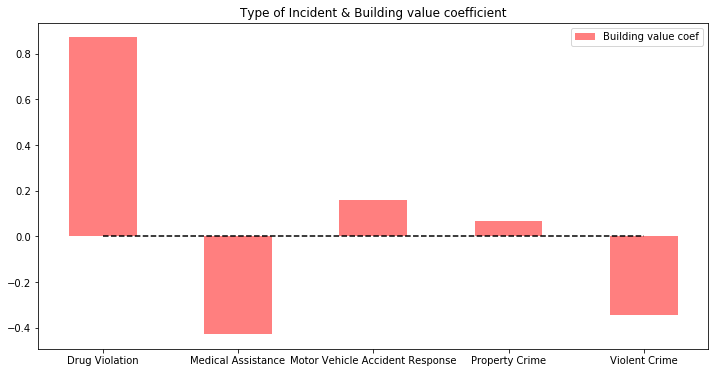

In [30]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["BLDG_VAL"], color="red", width=0.5, alpha=0.5)
plt.title("Type of Incident & Building value coefficient")
plt.legend(["Building value coef"])
plt.plot(offense_label, [0]*5, "k--")


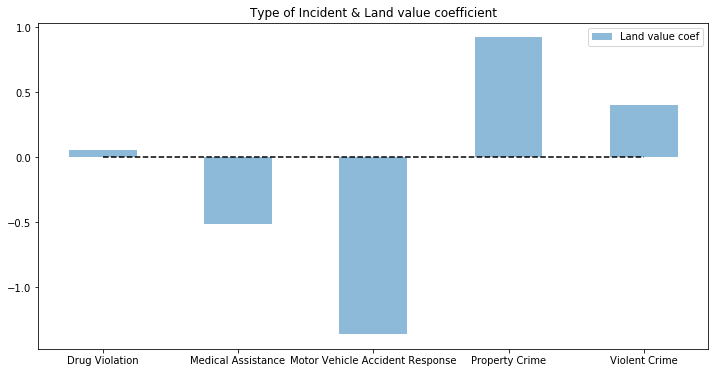

In [31]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["LAND_VAL"], width=0.5, alpha=0.5)
plt.title("Type of Incident & Land value coefficient")
plt.legend(["Land value coef"])
plt.plot(offense_label, [0]*5, "k--")


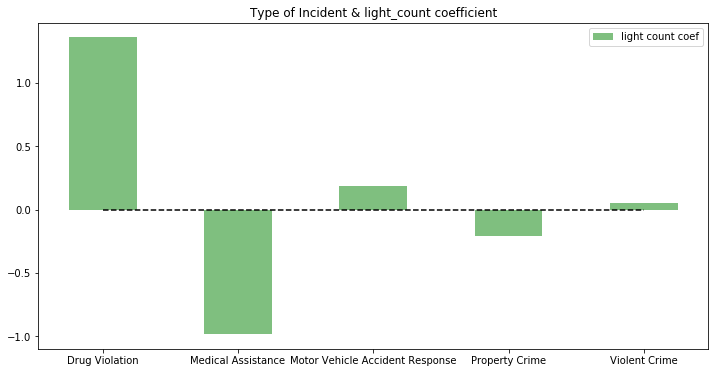

In [32]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["light_count"], width=0.5, color='green', alpha=0.5)
plt.title("Type of Incident & light_count coefficient")
plt.legend(["light count coef"])
plt.plot(offense_label, [0]*5, "k--")

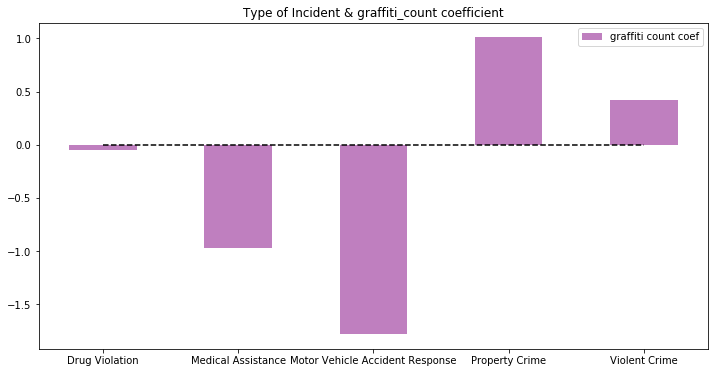

In [33]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["graffiti_count"], width=0.5, color='purple', alpha=0.5)
plt.title("Type of Incident & graffiti_count coefficient")
plt.legend(["graffiti count coef"])
plt.plot(offense_label, [0]*5, "k--")

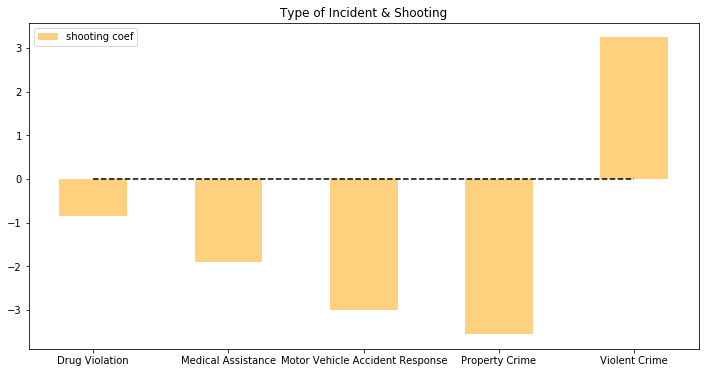

In [34]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["SHOOTING_1"], width=0.5, color='orange', alpha=0.5)
plt.title("Type of Incident & Shooting")
plt.legend(["shooting coef"])
plt.plot(offense_label, [0]*5, "k--")

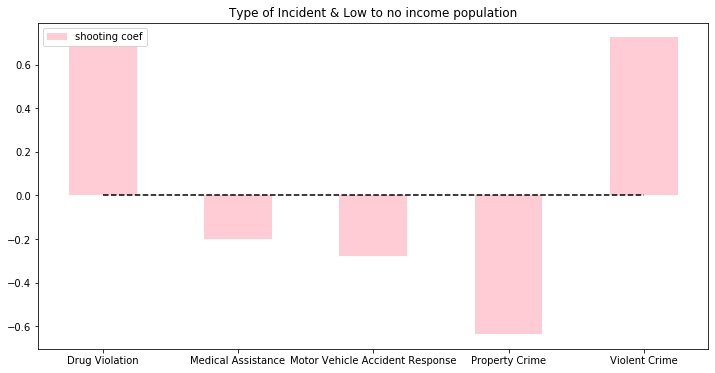

In [41]:
plt.figure(num=None, figsize=(12, 6))
plt.bar(offense_label, coefs["Low_to_No"], width=0.5, color='pink', alpha=0.8)
plt.title("Type of Incident & Low to no income population")
plt.legend(["shooting coef"])
plt.plot(offense_label, [0]*5, "k--")

In [36]:
knn = KNeighborsClassifier(n_neighbors = 12).fit(X_normalized, y_train) 
  
# accuracy on X_test 
accuracy = knn.score(X_normalized_tst, y_test) 
print(accuracy)

0.27628317948349557


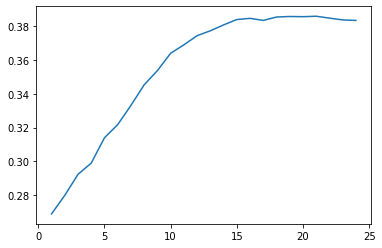

In [37]:
# decision tree with best depth by cv
depth_list = range(1,25)
score_list = []

for depth in depth_list:
#     print(depth)
    clf = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=depth)
    score = np.mean(cross_val_score(clf, X_normalized, y_train, cv=5))
    score_list.append(score)
plt.plot(depth_list, score_list)
plt.show()

In [38]:
best_depth = depth_list[np.argmax(score_list)]
best_depth

21

In [39]:
clf = DecisionTreeClassifier(random_state=0, max_depth=best_depth)
clf.fit(X_normalized, y_train)
clf.score(X_normalized_tst, y_test)

0.3937717754391006

[31 30 29 32  0  1 33 34 27 35 49  9 48 28 36 37 46 47 40 41 39 38 20 45
 12 10 42 19 44 11 13  8 18 43 14 16 17 15 23 22 21 25 24 26  7  2  5  6
  3  4]


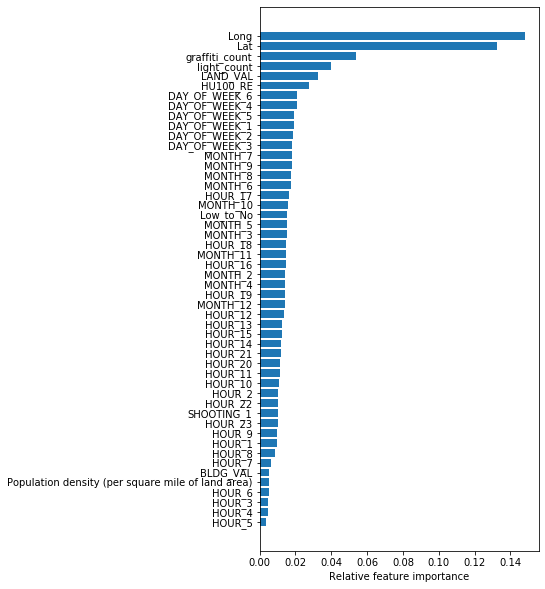

In [40]:
# plot feature importances
plt.figure(figsize=(5,10))
features = X_normalized.columns
feature_importances = clf.feature_importances_
idx = np.argsort(feature_importances)
print(idx)
plt.barh(y=features[idx], width=feature_importances[idx])
plt.xlabel("Relative feature importance")
plt.show()